In [1]:
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal
import pandas as pd
import sklearn.linear_model as lm
from matplotlib import pyplot as plt
import pyreadr

np.random.seed(65987833)
np.set_printoptions(formatter={'float_kind': '{:f}'.format})

## EXERCISE 2

I create a function to generate the data from a factor analysis model, and a function to compute the log-likelihood of the data under the factor analysis model. 

I then create the E-step and M-step functions for the EM algorithm for factor analysis. I also create a function to compute the Frobenius norm of the difference between two projection matrices. 

In [2]:
def gen_data(mu, Lambda, n=100, scale_1=1, scale_2=np.sqrt(0.4)):
    # generate data from a factor analysis model
    # inputs: mu: q x 1 mean vector
    #         Lambda: q x p factor loading matrix
    #         n: number of samples
    # returns: Y: n x q data matrix
    # generate latent variables
    p = Lambda.shape[1]
    X = np.random.normal(size=(n, p), scale=scale_1)
    # generate error
    q = mu.shape[0]
    W = np.random.normal(size=(n, q), scale=scale_2)
    # generate data
    Y = np.tile(mu, (n, 1)) + X @ Lambda.T + W
    return Y


def log_likelihood_FA_mmodel(mu, Lambda, Psi, Y):
    # compute the log-likelihood of the data under the factor analysis model
    # inputs: mu: q x 1 mean vector
    #         Lambda: q x p factor loading matrix
    #         Psi: q x q error covariance matrix
    #         Y: n x q data matrix
    # returns: ll: log-likelihood
    # helper matrix
    mean = mu
    cov = Lambda @ Lambda.T + Psi
    # log-likelihood
    ll = multivariate_normal.logpdf(Y, mean=mean, cov=cov)
    return ll.sum()


def E_step_FA_mmodel(mu, Lambda, Psi, Y):
    # E-step of the EM algorithm for factor analysis
    # inputs: mu: q x 1 mean vector
    #         Lambda: q x p factor loading matrix
    #         Psi: q x q error covariance matrix
    #         Y: n X q data vector
    # returns: e_X: n x p latent variable means, each row is a mean vector E[X_i|Y_i]
    #          v_X: n x p x p latent variable "covariance" tensor,
    #               each slice over the first axis is a matrix E[X_i X_i^T|Y_i]
    # helper matrix
    beta = Lambda.T @ np.linalg.inv(Lambda @ Lambda.T + Psi)
    # normalize Y by mu
    Y_norm = Y - np.tile(mu, (Y.shape[0], 1))
    # n x p matrix of latent variable means
    e_X = Y_norm @ beta.T
    # n x p x p tensor of outer products of rows of e_X
    outer_prod_tensor = np.einsum('ij,ik->ijk', e_X, e_X)
    # create p x p matrix common to all observations
    matrix = np.eye(Lambda.shape[1]) - beta @ Lambda
    # sum matrix with outer_prod_tensor to return n x p x p tensor
    v_X = np.tile(matrix, (Y.shape[0], 1, 1)) + outer_prod_tensor
    return e_X, v_X


def M_step_FA_mmodel(Y, e_X, v_X):
    # M-step of the EM algorithm for factor analysis
    # Y: n x q data matrix
    # e_X: n x p latent variable means
    # v_X: n x p x p latent variable "covariance" tensor
    # returns: mu: q x 1 mean vector
    #          Lambda: q x p factor loading matrix
    #          Psi: q x q error covariance matrix
    # mean vector
    mu = Y.mean(axis=0)
    # normalize Y by mu
    Y_norm = Y - np.tile(mu, (Y.shape[0], 1))
    # factor loading matrix
    Lambda = np.einsum('ij,ik->jk', Y_norm, e_X) @ np.linalg.inv(np.sum(v_X, axis=0))
    # error covariance matrix
    first_tens = np.einsum('ij,ik->ijk', Y_norm, Y_norm)
    second_tens = np.einsum('ij,ik->ijk',  e_X @ Lambda.T, Y_norm)
    Psi = np.diag(np.diag((first_tens - second_tens).mean(axis=0)))
    return mu, Lambda, Psi


def EM_FA_mmodel(Y, Lambda_start, max_iters=1000, tol=1e-6):
    # EM algorithm for factor analysis
    # Y: n x q data matrix
    # p: number of factors
    # max_iter: maximum number of iterations
    # tol: convergence tolerance
    # returns: mu: q x 1 mean vector
    #          Lambda: q x p factor loading matrix
    #          Psi: q x q error covariance matrix
    #          log_l: log-likelihood
    n, q = Y.shape
    # initialize mu, Lambda, Psi
    mu = Y.mean(axis=0)
    Lambda = Lambda_start
    Psi = np.eye(q)
    # EM algorithm
    for _ in range(max_iters):
        # E-step
        e_X, v_X = E_step_FA_mmodel(mu, Lambda, Psi, Y)
        # M-step
        mu_new, Lambda_new, Psi_new = M_step_FA_mmodel(Y, e_X, v_X)
        # check convergence
        if np.allclose(Lambda, Lambda_new, atol=tol) and np.allclose(Psi, Psi_new, atol=tol):
            break
        mu, Lambda, Psi = mu_new, Lambda_new, Psi_new
    # log-likelihood
    log_like = log_likelihood_FA_mmodel(mu, Lambda, Psi, Y)
    return mu, Lambda, Psi, log_like


def projection_norm(A, B):
    # compute the Frobenius norm of difference between two projection matrices P_A and P_B
    # inputs: A: q x p matrix
    #         A: q x p matrix
    # returns: ||A(A^t A)^{-1} A^t - B(B^t B)^{-1} B^t||_F
    try:
        P_A = A @ np.linalg.inv(A.T @ A) @ A.T
    except np.linalg.LinAlgError:
        P_A = 0
    try:
        P_B = B @ np.linalg.inv(B.T @ B) @ B.T
    except np.linalg.LinAlgError:
        P_B = 0
    # P_A = A @ np.linalg.inv(A.T @ A) @ A.T
    # P_B = B @ np.linalg.inv(B.T @ B) @ B.T
    return np.linalg.norm(P_A - P_B, ord='fro')

I then generate the data.

In [3]:
F = np.array([[1, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 1]],
             dtype=float).T
m = np.zeros(7)
data = gen_data(m, F, n=100)

### (a)

I then run the EM algorithm for factor analysis for different values of the noise parameter $\sigma$ and compare the log-likelihood of the data under the estimated model to the log-likelihood of the data under the true model.
 For each value of $\sigma$, I perform 500 simulations and then keep the best estimate of $\Lambda$. 

In [4]:
nsim = 500
max_iter = 1000
sigmas = [0.001, 0.01, 0.1, 1, 10]
log_ls = np.zeros((len(sigmas), nsim))
Lambda_estimates = []
for i, sigma in enumerate(tqdm(sigmas)):
    lambdas_sigma_runs = []
    for sim in range(nsim):
        Lambda0 = F + np.random.normal(scale=sigma, size=F.shape)
        _, Lambda_star, _, log_l_star = EM_FA_mmodel(data, Lambda0, max_iter)
        log_ls[i, sim] = log_l_star
        lambdas_sigma_runs.append(Lambda_star)
    Lambda_estimates.append(lambdas_sigma_runs[np.argmax(log_ls[i, :])])

100%|██████████| 5/5 [00:32<00:00,  6.43s/it]


In [5]:
print(f"True log-likelihood: {np.round(log_likelihood_FA_mmodel(m, F, 0.4 * np.eye(m.shape[0]), data), 3)}"
      f"\n\n"
      f"Estimated maximal log-likelihoods: \n"
      f"""{pd.DataFrame({"sigma": sigmas, "log_l": log_ls.max(axis=1).round(3)})}""")
for i, est in enumerate(Lambda_estimates):
    print(f"""{"-" * 70}""")
    print(f"sigma: {sigmas[i]}")
    print(f"Best Estimate:\n"
          f"{est}")

True log-likelihood: -931.603

Estimated maximal log-likelihoods: 
    sigma    log_l
0   0.001 -921.354
1   0.010 -921.354
2   0.100 -921.354
3   1.000 -921.354
4  10.000 -921.354
----------------------------------------------------------------------
sigma: 0.001
Best Estimate:
[[1.123962 0.043388]
 [1.165259 -0.087752]
 [1.018535 0.059031]
 [0.996227 0.939464]
 [-0.039074 0.920566]
 [-0.018579 1.033179]
 [0.030045 1.026288]]
----------------------------------------------------------------------
sigma: 0.01
Best Estimate:
[[1.124355 0.031705]
 [1.164287 -0.099857]
 [1.019097 0.048442]
 [1.005940 0.929060]
 [-0.029505 0.920922]
 [-0.007841 1.033316]
 [0.040710 1.025921]]
----------------------------------------------------------------------
sigma: 0.1
Best Estimate:
[[1.124828 -0.000131]
 [1.161018 -0.132771]
 [1.020084 0.019579]
 [1.031877 0.900220]
 [-0.003407 0.921392]
 [0.021433 1.033128]
 [0.069756 1.024361]]
----------------------------------------------------------------------
s

We can see from the result that no matter the value of sigma we converge to a solution achieving maximum likelihood.
All these estimates are very close to the true factor matrix and they are orthornormal transformations of one another.

### (b)

In [6]:
nsim = 100
norms = np.zeros((len(sigmas), nsim))
Lambda_estimates = []
Psi_estimates = []
log_ls = np.zeros((len(sigmas), nsim))
for i, sigma in enumerate(tqdm(sigmas)):
    lambdas_sigma_runs = []
    psis_sigma_runs = []
    for sim in range(nsim):
        Lambda_0 = np.random.normal(scale=sigma, size=F.shape)
        _, Lambda_star, _, log_l_star = EM_FA_mmodel(data, Lambda_0, max_iter)
        norms[i, sim] = projection_norm(F, Lambda_star)
        log_ls[i, sim] = log_l_star
        lambdas_sigma_runs.append(Lambda_star)
    best_index = np.argmin(norms[i, :])
    Lambda_estimates.append(lambdas_sigma_runs[best_index])

100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


In [7]:
for i in range(len(sigmas)):
    print(f"""{"-" * 70}\n"""
          f"sigma: {sigmas[i]}\n"
          f"Minimal distance in column space: {round(norms[i].min(), 3)}\n\n"
          f"Estimate achieving minimal distance in column space for sigma = {sigmas[i]}:\n "
          f"{np.round(Lambda_estimates[i], 3)}\n")
    print(f"Log-likelihood of our estimate: "
          f"{round(log_ls[i, np.argmin(norms[i, :])], 3)}")
    print(f"Log-likelihood of the true model: "
          f"{round(log_likelihood_FA_mmodel(m, F, 0.4 * np.eye(m.shape[0]), data), 3)}")
print(f"""{"-" * 70}\n""")
print(f"True factor matrix: \n {F}")

----------------------------------------------------------------------
sigma: 0.001
Minimal distance in column space: 0.148

Estimate achieving minimal distance in column space for sigma = 0.001:
 [[-1.091000 -0.272000]
 [-1.095000 -0.409000]
 [-0.995000 -0.227000]
 [-1.218000 0.625000]
 [-0.219000 0.895000]
 [-0.270000 0.997000]
 [-0.315000 0.977000]]

Log-likelihood of our estimate: -921.354
Log-likelihood of the true model: -931.603
----------------------------------------------------------------------
sigma: 0.01
Minimal distance in column space: 0.148

Estimate achieving minimal distance in column space for sigma = 0.01:
 [[-1.005000 0.506000]
 [-0.977000 0.641000]
 [-0.920000 0.441000]
 [-1.326000 -0.340000]
 [-0.411000 -0.825000]
 [-0.484000 -0.913000]
 [-0.523000 -0.884000]]

Log-likelihood of our estimate: -921.354
Log-likelihood of the true model: -931.603
----------------------------------------------------------------------
sigma: 0.1
Minimal distance in column space: 0.148

Now note that while our EM algorithm still converges to a Maximum Likelihood solution, now the estimates are not as close to the true factor matrix as before. This is due to the fact that we are starting from an initialization of $\Lambda$ that is random and not close to the true factor matrix. 
Indeed we see that no matter the value of $\sigma$, the best estimate we achieve always has 0.148 as minimal distance in column space from the true factor matrix. The corresponding best estimate of $\Lambda$ is always a rotation of the true factor matrix.

## EXERCISE 3

In [8]:
def M_step_FA_mmodel_LASSO(Y, e_X, v_X, Lambda_k):
    # M-step of the EM algorithm for factor analysis
    # Y: n x q data matrix
    # e_X: n x p latent variable means
    # v_X: n x p x p latent variable "covariance" tensor
    # returns: mu: q x 1 mean vector
    #          Lambda: q x p factor loading matrix
    #          Psi: q x q error covariance matrix
    n, q = Y.shape
    p = e_X.shape[1]
    # mean vector
    mu = Y.mean(axis=0)
    # normalize Y by mu
    Y_norm = Y - np.tile(mu, (Y.shape[0], 1))
    # update Psi
    first_tens = np.einsum('ij,ik->ijk', Y_norm, Y_norm)
    second_tens = np.einsum('ij,ik->ijk', e_X @ Lambda_k.T, Y_norm)
    Psi = np.diag(np.diag((first_tens - second_tens).mean(axis=0)))
    # compute the Cholesky decomposition of var[X], p x p matrices
    var_X = np.eye(p) - Lambda_k.T @ np.linalg.inv(Lambda_k @ Lambda_k.T + Psi) @ Lambda_k
    M = np.linalg.cholesky(var_X).T
    # create surrogate response matrix (n + p) x q and covariate matrix (n + p) x p
    Y_sur = np.concatenate((Y, np.zeros(shape=(p,q))), axis=0)
    X_sur = np.concatenate((e_X, np.sqrt(n) * M), axis=0)
    # compute the LASSO estimate of Lambda
    Lambda = np.zeros(Lambda_k.shape)
    lasso = lm.Lasso(alpha=1, fit_intercept=False, max_iter=1000, tol=1e-2)
    for q in range(Y.shape[1]):
        # update row q of Lambda
        lam = 0.0001
        penalty = lam * 2 * n * Psi[q, q]
        if penalty < 0:
            penalty = 0.00001
        lasso.set_params(alpha=penalty)
        Lambda[q] = lasso.fit(X_sur, Y_sur[:, q]).coef_
    # Lambda = np.einsum('ij,ik->jk', Y_norm, e_X) @ np.linalg.inv(np.sum(v_X, axis=0))
    return mu, Lambda, Psi

In [9]:
data = gen_data(m, F, n=100)

nsim = 100
sigmas = [0.01, 0.1]
norms = np.zeros((len(sigmas), nsim))
Lambda_estimates = []
for i, sigma in enumerate(tqdm(sigmas)):
    lambdas_sigma_runs = []
    for sim in range(nsim):
        Lambda_hat = np.random.normal(scale=sigma, size=F.shape)
        Psi_hat = np.eye(F.shape[0])
        mu_hat = np.zeros(F.shape[0])
        for _ in range(max_iter):
            cond_E_X, cond_V_X = E_step_FA_mmodel(mu_hat, Lambda_hat, Psi_hat, data)
            old_mu, old_Lambda, old_Psi = mu_hat, Lambda_hat, Psi_hat
            mu_hat, Lambda_hat, Psi_hat = M_step_FA_mmodel_LASSO(data, cond_E_X, cond_V_X, Lambda_hat)
            if np.allclose(old_Lambda, Lambda_hat) and np.allclose(old_Psi, Psi_hat):
                norms[i, sim] = projection_norm(F, Lambda_hat)
                lambdas_sigma_runs.append(Lambda_hat)
                break
    Lambda_estimates.append(lambdas_sigma_runs[np.argmin(norms[i, :])])

100%|██████████| 2/2 [00:44<00:00, 22.36s/it]


In [10]:
for i in range(len(sigmas)):
    print(f"""{"-" * 70}\n"""
          f"sigma: {sigmas[i]}\n"
          f"{np.round(Lambda_estimates[i], 3)}\n")

----------------------------------------------------------------------
sigma: 0.01
[[0.000000 0.000000]
 [0.000000 0.000000]
 [0.000000 0.000000]
 [0.000000 0.000000]
 [0.000000 0.000000]
 [0.000000 0.000000]
 [0.000000 0.000000]]

----------------------------------------------------------------------
sigma: 0.1
[[0.982000 0.056000]
 [0.930000 -0.000000]
 [0.973000 -0.089000]
 [0.965000 -1.126000]
 [-0.019000 -1.118000]
 [0.059000 -1.223000]
 [0.000000 -1.109000]]


We see that for $\sigma = 0.1$ we converge to the correct solution. The only issue depends on the sign of the columns, which again represents a rotation of the true factor matrix.

## EXERCISE 4

I create a function to compute the MDS projection of a distance matrix.

In [11]:
def MDS(Dis, p=2):
    # compute the MDS projection
    # inputs: Dis: n x n distance matrix
    #         p: number of dimensions
    # returns: X: n x p data matrix
    # number of samples
    n = Dis.shape[0]
    # centering matrix
    H = np.eye(n) - np.ones((n, n)) / n
    # compute the kernel matrix
    K = - 0.5 * H @ np.square(Dis) @ H
    # compute the eigenvalues and eigenvectors
    D, U = np.linalg.eig(K)
    # sort the eigenvalues and eigenvectors
    idx = np.argsort(D)[::-1]
    D = D[idx]
    U = U[:, idx]
    # get the number of non-zero eigenvalues and choose at most that many pcs
    p = min(p, np.sum(D > 0))
    # select the first p eigenvalues and eigenvectors
    D = D[:p]
    U = U[:, :p]
    # compute the MDS projection
    X = U @ np.diag(np.sqrt(D))
    return X

I then use the function to compute the MDS projection of the distance matrix for the 10 cities in the example.
And scatter plot the MDS projection to reconstruct an approximate map of the US.

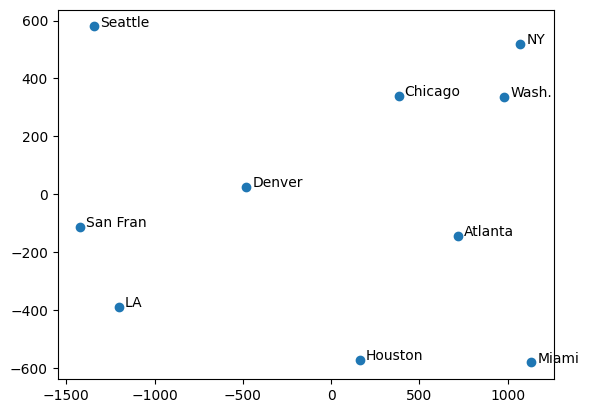

In [12]:
D_matrix = np.array([[0, 587, 1212, 701, 1936, 604, 748, 2139, 2182, 543],
                     [587, 0, 920, 940, 1745, 1188, 713, 1858, 1737, 597],
                     [1212, 920, 0, 879, 831, 1726, 1631, 949, 1021, 1494],
                     [701, 940, 879, 0, 1374, 968, 1420, 1645, 1891, 1220],
                     [1936, 1745, 831, 1374, 0, 2339, 2451, 347, 959, 2300],
                     [604, 1188, 1726, 968, 2339, 0, 1092, 2594, 2734, 923],
                     [748, 713, 1631, 1420, 2451, 1092, 0, 2571, 2408, 205],
                     [2139, 1858, 949, 1645, 347, 2594, 2571, 0, 678, 2442],
                     [2182, 1737, 1021, 1891, 959, 2734, 2408, 678, 0, 2329],
                     [543, 597, 1494, 1220, 2300, 923, 205, 2442, 2329, 0]],
                    dtype=float)
coords = MDS(D_matrix, 2)
cities = ['Atlanta', 'Chicago', 'Denver', 'Houston', 'LA', 'Miami', 'NY', 'San Fran', 'Seattle', 'Wash.']
plt.scatter([coords[:, 0]], [coords[:, 1]])
for i, txt in enumerate(cities):
    plt.annotate(txt, (coords[i, 0] + 35, coords[i, 1]))
# plt.savefig('./figures/mds_map.png')
plt.show()

As we can see, the MDS projection of the distance matrix for the 10 cities in the example reconstructs an approximate map of the US.

## EXERCISE 5

I first create functions to compute the linear, RBF, and polynomial kernel matrices.
I then create a function to compute the kernel PCA projection of a data matrix. 

In [13]:
def center_data(Y):
    # center the data
    # inputs: Y: n x p data matrix
    # returns: Y: n x p centered data matrix
    Y = Y - np.tile(np.mean(Y, axis=0), (Y.shape[0], 1))
    return Y


def center_kernel(K):
    # center the kernel matrix
    # inputs: K: n x n kernel matrix
    # returns: K: n x n centered kernel matrix
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    K = H @ K @ H
    return K


def linear_kernel(Y, center=True):
    # compute the linear kernel matrix
    # inputs: Y: n x p data matrix
    # returns: K: n x n kernel matrix
    if center:
        Y = center_data(Y)
    return Y @ Y.T


def rbf_kernel(Y, gamma=None, center=True):
    # compute the RBF kernel matrix
    # inputs: Y: n x p data matrix
    #         gamma: kernel width
    # returns: K: n x n kernel matrix
    if center:
        Y = center_data(Y)
    if gamma is None:
        gamma = 1 / Y.shape[1]
    n = Y.shape[0]
    Y_sq = np.sum(Y ** 2, axis=1)
    Y_sq = np.tile(Y_sq, (n, 1))
    K = Y_sq + Y_sq.T - 2 * Y @ Y.T
    return np.exp(- gamma * K)


def poly_kernel(Y, degree=2, gamma=None, c=1, center=True):
    # compute the polynomial kernel matrix
    # inputs: Y: n x p data matrix
    #         degree: degree of the polynomial
    #         gamma: scaling factor
    #         c: constant term
    # returns: K: n x n kernel matrix
    # compute the kernel matrix
    if center:
        Y = center_data(Y)
    if gamma is None:
        gamma = 1 / Y.shape[1]
    K = (gamma * (Y @ Y.T) + c) ** degree
    return K


def kernel_PCA_proj(K, pcs=1, center=True):
    if center:
        K = center_kernel(K)
    D, U = np.linalg.eig(K)
    # get the number of non-zero eigenvalues and choose at most that many pcs
    pcs = min(pcs, np.sum(D > 0))
    # sort the eigenvalues and eigenvectors
    idx = np.argsort(D)[::-1]
    D = D[idx]
    U = U[:, idx]
    return U[:, :pcs] @ np.diag(np.sqrt(D[:pcs]))

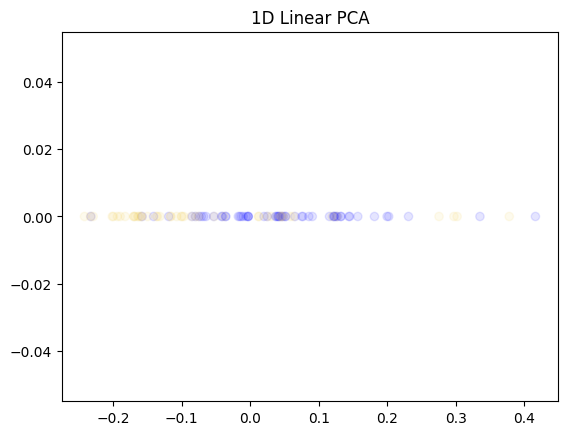

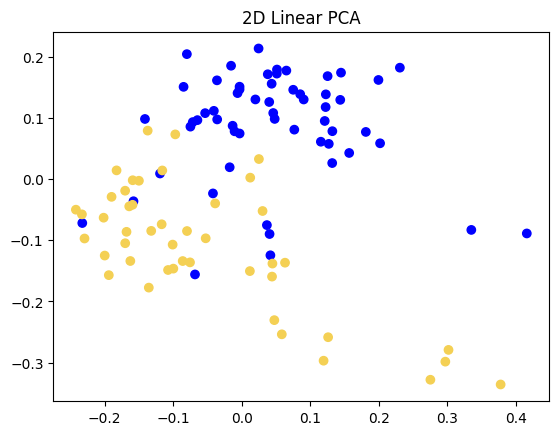

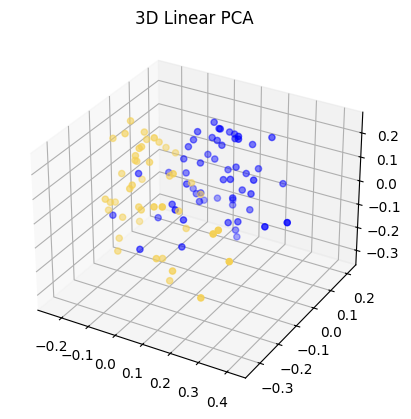

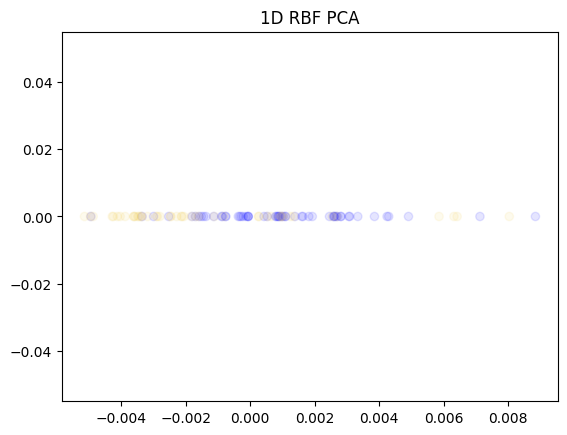

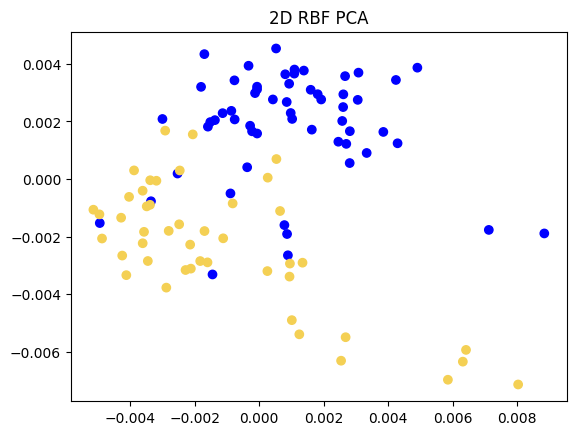

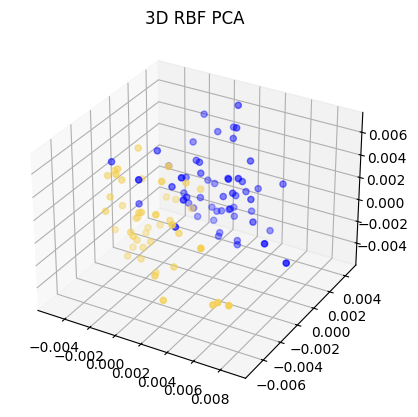

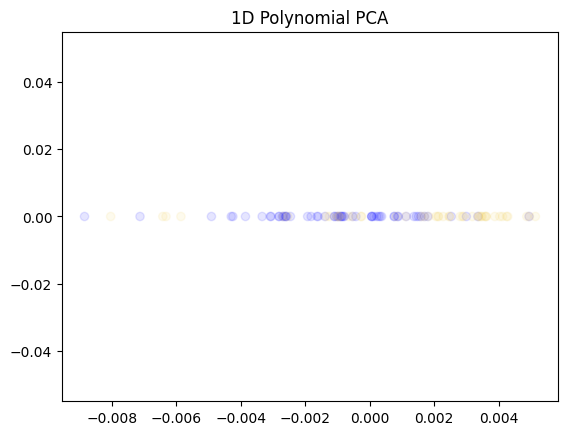

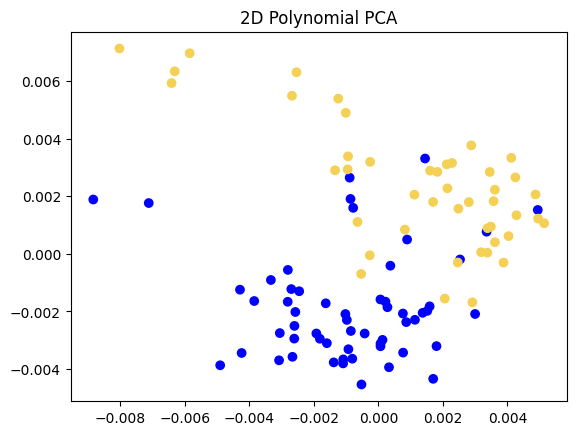

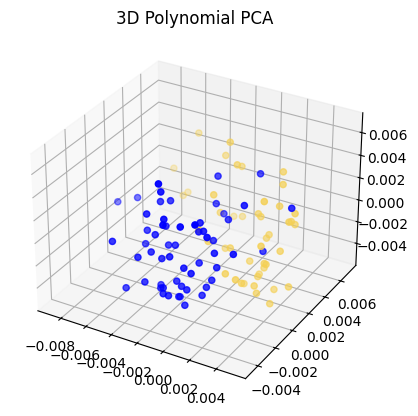

In [14]:
nyt_frame = pyreadr.read_r('./data/nytimes.RData')["nyt.frame"]
labels = nyt_frame["class.labels"]
labels = (labels == "art").values.astype(int)
colors = np.array(["xkcd:maize", "blue"])[labels]
data = nyt_frame.drop("class.labels", axis=1).to_numpy()

kernels = [linear_kernel(data),
           rbf_kernel(data),
           poly_kernel(data)]
kernel_names = ["Linear", "RBF", "Polynomial"]

for i, kernel in enumerate(kernels):
    proj_1d = kernel_PCA_proj(kernel, 1)
    plt.scatter(proj_1d, np.zeros_like(proj_1d), c=colors, alpha=0.1)
    plt.title(f"1D {kernel_names[i]} PCA")
    plt.show()
    proj_2d = kernel_PCA_proj(kernel, 2)
    plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c=colors)
    plt.title(f"2D {kernel_names[i]} PCA")
    plt.show()
    proj_3d = kernel_PCA_proj(kernel, 3)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=colors)
    plt.title(f"3D {kernel_names[i]} PCA")
    plt.show()

We see that all three kernel PCA projections are able to separate the two classes of documents in 2 dimensions. Moreover, the projections are exactly equivalent in this dimensionality, as they are rotations of each other.